# Intro to Seismology: Programming for Homework 3
## Name: 

## Introduction

The goal of this assignment is to locate an earthquake based on travel times.  To do this will require three ingredients 

  1. A function that generates travel times from any point in the media to all receivers.
     - We will use a closed-form solution to the eikonal equation in a homogeneous medium.
  2. A way to compare the estimated and observed travel times.
     - We will use least-squares.
  3. A strategy for finding a model that better predicts the correct observed travel times.
     - We will use gradient-based nonlinear optimization (Geiger's method) and grid-search.


In [1]:
# includes and convenience functions
import matplotlib.pyplot as plt
from numpy import amin, amax
from numpy import argmin, argmax, unravel_index
from numpy import zeros
from numpy import median
from numpy import linspace
from numpy import exp
from numpy import meshgrid
from numpy import average
from numpy import copy
from numpy import sqrt
from numpy.linalg import lstsq

def unpackModel(model):
    """!
    Convenience function to unpack model stored as a vector.
    
    Parameters
    ----------
    model : array_like
        Model to unpack.  
        
    Returns
    -------
    xs : double
        x source position in meters.
    ys : double
        y source position in meters.
    t0 : double
        Origin time in seconds.
    """
    xs = model[0]
    ys = model[1]
    t0 = model[2]
    return xs, ys, t0

def packModel(xs, ys, t0):
    """!
    Convenience function to pack the model as a vector.
           
    Parameters
    ----------
    xs : double
        x source position in meters.
    ys : double
        y source position in meters.
    t0 : double
        Origin time in seconds.
    
    Returns
    -------
    model : array_like
        Model parameters packed as a vector.
    """
    model = zeros(3)
    model[0] = xs
    model[1] = ys
    model[2] = t0
    return model

## Modeling Travel Times

In a homogeneous medium the estimated travel time, $t_{est}$, is simply the distance, $d$, divided by the medium velocity, $v$, i.e., $t_{est} = \frac{d}{v}$.  Moreover, observe that earthquakes have unknown origin times, $t_0$.  Thus, the estimated travel time function must add some bias corresponding to the origin time, i.e., $t_{est} = t_0 = \frac{d}{v}$.  For ease of implementation, we will consider only a $2D$ media, so that distance between the source, $\textbf{x}_s$, and receiver, $\textbf{x}_j$, is $d = \sqrt{ (x_j - x_s)^2 + (y_j - y_s)^2}$.  Therefore, our travel time function modeled at the $j$'th receiver is

\begin{equation}
  T_{est}^{(j)}(t_0, \textbf{x}_s) 
 =t_0 + \frac{\sqrt{ (x_j - x_s)^2 + (y_j - y_s)^2}}{v}
\end{equation}

In general it will be more convenient to define the model as $\textbf{m} = \{x_s, y_s, t_0 \}$ so that

\begin{equation}
  T_{est}^{(j)}(\textbf{m}) 
 =t_0 + \frac{\sqrt{ (x_j - x_s)^2 + (y_j - y_s)^2}}{v}
\end{equation}

In [2]:
def computeTravelTimes(xr, yr, vel, model):
    """
    Computes travel times in a 2D homogeneous medium with contant velocity.
    
    Parameters
    ----------
    xr : array_like
        The x positions of the receivers (meters).  This has dimension [nrec]
        where nrec is the number of receivers.
    yr : array_like
        The y positions of the receivers (meters).  This has dimension [nrec]
        where nrec is the number of receivers.
    vel : double
        The constant velocity in the medium (meters/seconds).
    model : array_like
        The model that contains the source location in (x,y) as well as the origin time.
        
    Returns
    -------
    test : array_like
        The estimate travel times from the source to each receiver (seconds).
    """
    xs, ys, t0 = unpackModel(model)
    test = # Put your code here 
    return test

## Measuring Misfit

In all inverse problems a measure of how well the model explains the data is required.  Such measures are typically called objective or cost funtcions.  Many objective functions exist and each has its own merits and drawbacks.  Arguably, the most common objective function is the sum of the residuals squared.  Least-squares typically yields quick convergence in non-linear inversions and results in simple very algebra.  Unfortunately, outliers can have an undo influence on the solution and therefore, least-squares is not robust.  To mitigate the last point, it is generally intelligent to screen data and manually remove outlier data prior to inversion.  That said, the misfit (cost) function to minimize looks like

\begin{equation}
  \mathcal{C}(\textbf{m}) = \sum_{j=1}^{n_{obs}} (T_{obs}^{(j)} - T_{est}^{(j)}(\textbf{m}) )^2  
\end{equation}

where we are simply squaring and summing the residual travel times for all $n_{obs}$ observations.  If only locating with $P$ waves then the number of observations would be the number of receivers in the network.  Notice, the residual is the difference between the observed travel time, $T_{obs}^{(j)})$, and estimate travel time for the $j$'th observation.

In [3]:
def computeResiduals(tobs, test):
    """
    Computes the residuals.
    
    Parameters
    ----------
    tobs : array_like
         The observations in seconds.  This has dimension [nrec] which is 
         the number of receivers.
    test : array_like
         The estimates in seconds.  This has dimension [nrec] which is the 
         number of recievers.

    Returns
    -------
    res : array_like
         The travel time residuals in seconds.
    """
    res = # Put your code here
    return res

def computeCostFunction(model, tobs, xr, yr, vel):
    """
    Computes the cost (objective) function corresponding to the current model.
    
    Parameters
    ----------
    model : array_like
         Contains the current source position and origin time.
    tobs : array_like
         The observed travel times (seconds).  This has dimension [nrec] which is
         the number of receivers (observations).
    xr : array_like
         The receiver positions in x in meters.  This has dimension [nrec].
    yr : array_like
         The receiver positions in y in meters.  This has dimension [nrec].
    vel : double
         The constant velocity in the medium in meters/second.

    Returns
    -------
    cost : double
         The sum of the squared residuals.
    """
    # Compute the estimate travel times with computeTravelTimes
    test = # Put your code here
    # Compute the residuals with computeResiduals
    res = # Put your code here 
    # Compute the sum of the squared residuals (e.g., sum(res*res))
    cost = # Put your code here 
    return cost

## Geiger's Method

The iterative solution to minimizing the previous cost function was developed well before the advent of computers in 1910 by Geiger.  In principle the proposed solution is no different than iteratively minimizing a function in Calculus I.  The difference between Geiger's method and a Calculus I optimization problem is that there are four parameters (a hypocenter and origin) comprising an optimum instead of one.  

Ideally, we desire an optimal model, $\textbf{m}^*$ that yields a produces a cost function whose every residual is identically $0$
\begin{equation}
  \mathbf{r}(\textbf{m}^*) = \textbf{0}
\end{equation}

Here each row of the residual vector $\mathbf{r}(\textbf{m}^*) = \textbf{0}$ is an equation of the form 
$T_{obs}^{(j)} - T_{est}^{(j)} = 0$.  By inspection, we note that $\mathcal{C} = \mathbf{r}^T \cdot \mathbf{r}$ is indeed the sum of the residuals squared.

In general, we don't know $\textbf{m}^*$.  Instead, we guess it to be some initial model, $\textbf{m}_0$.  Then, we look for a perturbation, $\textbf{m}_1 \leftarrow \textbf{m}_0 + \alpha \textbf{p}$, so that $\textbf{m}_1$ is a better approximation to $\textbf{m}^*$.  Here $\alpha$ is a unitless 'step-length' that scales the search-direction, $\textbf{p}$.  The search direction necessarily has units equivalent to the model, i.e., $\textbf{p} = \{\Delta x, \Delta y, \Delta t\}$.  For the time being, let's ignore $\alpha$ though in practice it is a very important parameter whose estimation requires a difficult class of algorithms called line-search methods.  Thus, we seek a solution to the over-determined system 

\begin{equation}
  \mathbf{r}(\textbf{m}_0 + \textbf{p}) 
 =\textbf{0}
\end{equation}

Such a formulation is of little practical value so we linearize the above with a Taylor expansion about $ \textbf{p}$ 

\begin{align}
   \mathbf{r}(\textbf{m}_0 + \textbf{p})
&=\mathbf{r}(\textbf{m}_0) 
 + \nabla_{\textbf{m}}  \mathbf{r}(\textbf{m}_0) \textbf{p}
 +\cdots \\
&\approx
  \mathbf{r}(\textbf{m}_0) 
 +\nabla_{\textbf{m}}  \mathbf{r}(\textbf{m}_0) \textbf{p}
%+\frac{1}{2} \alpha^2 \textbf{p}^T \nabla  \mathbf{r}(\textbf{m}_0)^T \cdot \nabla  \mathbf{r}(\textbf{m}_0) \textbf{p} 
\end{align}

Recalling that the above should equal $\textbf{0}$ we can solve for the search direction

\begin{equation}
  \mathbf{r}(\textbf{m}_0) + \nabla_{\textbf{m}} \mathbf{r}(\textbf{m}_0) \cdot \textbf{p} = 0
\end{equation}

Note, that the gradient of a vector involves computing an outer-product.  This yields a matrix.  The matrix is known as the Jacobian matrix, $\nabla_{\textbf{m}} r(\textbf{m}) = J(\textbf{m})$ and is of great consequence to inverse problems.  To obtain a search direction we solve a system of over-determined equations

\begin{equation}
 J(\textbf{m}_0) \cdot \textbf{p} =-\mathbf{r}(\textbf{m}_0)
\end{equation}

whose solution is conventionally written as the normal equations

\begin{equation}
  \textbf{p} =-(J^T J)^{-1} J^T \textbf{r}(\textbf{m}_0)
\end{equation}

The term $J^T \textbf{r}$ is the gradient of the objective function, $\nabla_{\textbf{m}} \mathcal{C}$.  Indeed, if we approximate $(J^T J)^{-1}$ as the identity matrix, then we are left with something of the form $\textbf{p} =-J^T \textbf{r} =-\textbf{g}$.  This says that the update direction is the negative of the gradient.  This result is very intuitive and indicates that to optimize this nonlinear function we should simply march down the gradient of the objective function.  Recall, that the gradient points in the direction of maximum increase so a negative gradient points in the direction in the direction of maximum decrease.  This particularly optimization scheme is steepest descent. 

Finally, the location algorithm proceeds as follows:

   1.  Specify an initial model $\textbf{m}_0 = (x_s, y_s, t_0)$.
   2.  Compute the objective function, $\mathcal{C}(\textbf{m}_0)$.  If the objective function is small enough then stop.
   3.  Compute the search direction either by solving $J \textbf{p} =-\textbf{f}$ (Gauss-Newton) or $\textbf{p} =-J^T \textbf{r}$ (steepest-descent).
   4.  Update the model $\textbf{m}_1 = \textbf{m}_0 - \alpha \textbf{p}$ where we will take $\alpha = 1$ for Gauss-Newton or some small number $\ll 1$ for steepest-descent. 
   5.  Iterate

In [4]:
def computeGaussNewtonSearchDirection(model, tobs, xr, yr, vel):
    """
    Computes the Gauss-Newton search direction from the Jacobian and residual
    in a numerically stable way by solving the normal equations, Jp=r, with the
    singular value decomposition instead of the normal equations. 

    Parameters
    ----------
    model : Array of length 3
        This is an array containing the model. 
    tobs : array_like
        These are the observed travel times in second.  This has dimension [nrec]
        which corresponds to the number observations.
    xr : array_like
        These are the x positions (meters) of each reciever.  This has dimension [nrec]
        which corresponds to the number of receivers and observations.
    yr : array_like
        These are the y positions (meters) of each receiver.  This has dimension [nrec]
        which corresponds to the number of receivers and observations.
    vel : double
        This is the constant velocity in the medium.
        
    Returns
    -------
    p : array_like
        The Gauss-Newton search direction.  This has dimension [3] and is paked
        in the same order as the model so that m1 = m0 - alpha*p.
    """ 
    # Compute the Jacobian with computeJacobian
    J = # Put your code here
    # Compute the estimate travel times with computeTravelTimes
    test = # Put your code here 
    # Compute the residuals with computeResidiuals
    res = # Put your code here 
    # The normal equations are equivalent to solving the overdetermined
    # system J p =-r        
    p = lstsq(J, -res, rcond=-1)[0]
    return p

def computeSteepestDescentSearchDirection(model, tobs, xr, yr, vel):
    """
    Computes the steepest descent search direction from the Jacobian and residual.

    Parameters
    ----------
    model : Array of length 3
        This is an array containing the model. 
    tobs : array_like
        These are the observed travel times in second.  This has dimension [nrec]
        which corresponds to the number observations.
    xr : array_like
        These are the x positions (meters) of each reciever.  This has dimension [nrec]
        which corresponds to the number of receivers and observations.
    yr : array_like
        These are the y positions (meters) of each receiver.  This has dimension [nrec]
        which corresponds to the number of receivers and observations.
    vel : double
        This is the constant velocity in the medium.
        
    Returns
    -------
    p : array_like
        The Gauss-Newton search direction.  This has dimension [3] and is paked
        in the same order as the model so that m1 = m0 - alpha*p.
    """
    # Compute the Jacobian with computeJacobian
    J = # Put your code here
    # Compute the estimate travel times with computeTravelTimes
    test = # Put your code here 
    # Compute the residuals with computeResidiuals
    p =-J.T@res # negative of gradient
    return p

### Computing Derivatives 

Geiger's method is a gradient-descent technique that naturally requires derivatives of the cost function.  Recall, our objective function looks like

\begin{equation}
  \mathcal{C}(t_0, \textbf{x}_s) = \sum_{j=1}^{n_{obs}} (T_{obs}^{(j)} - T_{est}^{(j)}(\textbf{m}) )^2 = \sum_{r=1}^{n_{rec}} \left (T_{obs}^{(r)} - \left ( t_0 + \frac{\sqrt{ (x_j - x_s)^2 + (y_j - y_s)^2}}{v} \right ) \right )^2 
\end{equation}

Here what is required are the derivatives of the cost-function that comprise the gradient:

\begin{equation}
   \frac{\partial \mathcal{C}}{\partial x_s}
 =\sum_{j=1}^{n_{obs}} -2(T_{obs}^{(j)} - T_{est}^{(j)}) \frac{\partial T_{est}^{(j)}}{\partial x_s}
 = 2 \sum_{j=1}^{n_{obs}} (T_{obs}^{(j)} - T_{est}^{(j)}) \frac{(x_j - x_s)}{v \sqrt{(x_j-x_s)^2 + (y_j-y_s)^2}}
\end{equation}
\begin{equation}
   \frac{\partial \mathcal{C}}{\partial y_s}
 =\sum_{j=1}^{n_{obs}} -2(T_{obs}^{(j)} - T_{est}^{(j)}) \frac{\partial T_{est}^{(j)}}{\partial y_s}
 = 2 \sum_{j=1}^{n_{obs}} (T_{obs}^{(j)} - T_{est}^{(j)}) \frac{(y_j - y_s)}{v \sqrt{(x_j-x_s)^2 + (y_j-y_s)^2}}
\end{equation}
\begin{equation}
   \frac{\partial \mathcal{C}}{\partial t_0}
 =\sum_{j=1}^{n_{obs}} -2(T_{obs}^{(j)} - T_{est}^{(j)}) \frac{\partial T_{est}^{(j)}}{\partial t_0}
 =-2 \sum_{j=1}^{n_{obs}} (T_{obs}^{(j)} - T_{est}^{(j)}) 
\end{equation}

Defining the residual, $r_j$, for the $j$'th observation as $r_j \equiv T_{obs}^{(j)} - T_{est}^{(j)}$, and the distance between the $j$'th source and receiver, $d_j$, as $d_j \equiv \sqrt{ (x_j - x_s)^2 + (y_j - y_s)^2}$ allows us to write the compactly as 
\begin{equation}
   \frac{\partial \mathcal{C}}{\partial x_s}
 = 2 \sum_{j=1}^{n_{obs}} r_j \frac{(x_j - x_s)}{v d_j}
\end{equation}
\begin{equation}
   \frac{\partial \mathcal{C}}{\partial y_s}
 = 2 \sum_{j=1}^{n_{obs}} r_j \frac{(y_j - y_s)}{v d_j}
\end{equation}
\begin{equation}
   \frac{\partial \mathcal{C}}{\partial t_0}
 =-2 \sum_{j=1}^{n_{obs}} r_j 
\end{equation}


### The Jacobian Matrix

Notice that the gradient has a common $\sum_{j=1}^{n_{obs}} r_j$ term scaled by some coefficient.  We can rewrite the above has a matrix-vector multiplication 

\begin{equation}
  \nabla \mathcal{C} 
 =
  \left [
   \begin{array}{cccc}
     \frac{2(x_1 - x_s)}{d_1} & \frac{2(x_2 - x_s)}{d_2} & \cdots & \frac{2(x_{n_{obs}} - x_s)}{d_{n_{obs}}} \\
     \frac{2(y_1 - y_s)}{d_1} & \frac{2(y_2 - y_s)}{d_2} & \cdots & \frac{2(y_{n_{obs}} - y_s)}{d_{n_{obs}}} \\
     -2 & -2 & \cdots & -2
   \end{array}
  \right ]
  \left \{
    \begin{array}{c}
      T_{obs}^{(1)} - T_{est}^{(1)} \\
      T_{obs}^{(2)} - T_{est}^{(2)} \\
      \vdots \\
      T_{obs}^{(n_{rec})} - T_{est}^{(n_{obs})} \\
    \end{array}
  \right \}
 =\left [
   \begin{array}{cccc}
     \frac{2(x_1 - x_s)}{d_1} & \frac{2(x_2 - x_s)}{d_2} & \cdots & \frac{2(x_{n_{obs}} - x_s)}{d_{n_{obs}}} \\
     \frac{2(y_1 - y_s)}{d_1} & \frac{2(y_2 - y_s)}{d_2} & \cdots & \frac{2(y_{n_{obs}} - y_s)}{d_{n_{obs}}} \\
     -2 & -2 & \cdots & -2
   \end{array}
  \right ]
  \left \{
    \begin{array}{c}
      r_1 \\
      r_2 \\
      \vdots \\
      r_{n_{obs}} \\
    \end{array}
  \right \}\end{equation}

This form has a well-known form and is compactly written as something we've already seen

\begin{equation}
  \nabla \mathcal{C} = J^T \textbf{r}
\end{equation}

Again, the matrix, $J$, is the Jacobian matrix and gives us insights into the sensitivity of the model parameters to different observations.  The Jacobian matrix is essential in higher-order methods with faster convegence like Gauss-Newton optimization are second order.  Recall, the Gauss-Newton search direction, $\textbf{p}$, is found by computing

\begin{equation}
  J^T J \textbf{p} =-\nabla J^T \textbf{r}
\end{equation}

or 

\begin{equation}
  \textbf{p} =-(J^T J)^{-1} J^T \textbf{r}
\end{equation}

with model update given by $\textbf{m}_{k+1} = \textbf{m}_k + \alpha \textbf{p}$.  For (Gauss)-Newton steps $\alpha$ is typically $1$.  The algorithm should try small values of $\alpha$ should $\alpha=1$ prove to not reduce the objective function - i.e., we've stepped too far.  Something to keep in mind, $J$ is usually ill-conditioned. Computing $J^T J$ then squares the condition number of $J$.  Hence, inverting $J^T J$ is very difficult.  It is advised to use the QR decomposition or SVD instead of the Cholesky decomposition of the normal equations.  Shifting the small singular values (eigenvalues) of $J^T J$ away from zero by adding a diagonal regularization matrix like $J^T J + \gamma I$ is a common strategy to mitigate the dramatic effect that small singular values can have on the solution.

As shown previously, if we set $J^T J$ to the identity matrix, $I$, so that $(J^T J)^{-1} = I^{-1} = I$, then we obtain the steepest-descent method from the Gauss-Newton method as the search direction is simply

\begin{equation}
  \textbf{p} =-J^T \textbf{r}
\end{equation}

Note, for problems of appreciable size the Jacobian matrix is expensive to store and explicity compute.  For this reason, like in full-waveform inversion, we typically compute the action of $J$ on a vector of residuals and avoid its explicit construction.  More sophisticated algorithms like conjugate-gradient or the the limited memory BFGS algorithm can approximate the inverse of $J^T J$ and considerably increase convergence rates for a very small cost in system random access memory (RAM).  For this reasion l-BFGS and conjugate gradient are typically used for large-scale optimization problems in seismology as they balance low-memory footprint of steepest-descent with the convergence rate of Gauss-Newton.

In [5]:
def computeJacobian(model, xr, yr, vel):
    """
    Computes the Jacobian for the 2D travel time location in a homogeneous medium.
    The derivatives in the Jacobian are analytically computed.
    
    Parameters
    ----------
    model : Array of length 3
        This is an array containing the model.  
    xr : array_like
        These are the x positions (meters) of each reciever.  This has dimension [nrec]
        which corresponds to the number of receivers and observations.
    yr : array_like
        These are the y positions (meters) of each receiver.  This has dimension [nrec]
        which corresponds to the number of receivers and observations.
    vel : double
        This is the constant velocity in the medium.
    
    Returns
    -------
    J : Matrix
        The [nobs x 3] Jacobian matrix.  Here, nobs is the number of observations which
        equals the number of receivers.  The gradient is readily obtained by computing
    """
    # Unpack the model
    xs, ys, t0 = unpackModel(model) 
    # Allocate space for the Jacobian matrix
    nrows = len(xr)    # The number of rows in the Jacobian is the number of observations
    ncols = len(model) # The number of columns in the Jacobian is the dimension of the model spcae
    J = zeros([nrows, ncols])
    # Loop on observations 
    for irow in range(nrows):
        # It's possible to get a division by zero.  Technically the singularity goes to infinity.
        # But, for numerical reasons I'll force it to 0.  The trickery here is that the denominator
        # will be shifted away from zero and the numerator will evaluate to 0
        d = max(1.e-14, sqrt( (xr[irow] - xs)**2 + (yr[irow] - ys)**2 )) # Can get division by 0
        J[irow,0] = # Put your code here for dC_{irow}/dx 
        J[irow,1] = # Put your code here for dC_{irow}/dy 
        J[irow,2] = # Put your code here for dC_{irow}/dt 
    return J

def computeGradient(model, tobs, xr, yr, vel):
    """
    Computes the gradient of the objective function for the 2D 
    homogeneous velocity model.
    
    Parameters
    ----------
    model : Array of length 3
        This is an array containing the model. 
    tobs : array_like
        These are the observed travel times in second.  This has dimension [nrec]
        which corresponds to the number observations.
    xr : array_like
        These are the x positions (meters) of each reciever.  This has dimension [nrec]
        which corresponds to the number of receivers and observations.
    yr : array_like
        These are the y positions (meters) of each receiver.  This has dimension [nrec]
        which corresponds to the number of receivers and observations.
    vel : double
        This is the constant velocity in the medium.
        
    Returns
    -------
    grad : array_like
        The gradient of the objective function.  This has dimension [3] and is packed
        in the same order as the model so that m1 = m0 - alpha*grad.
    """
    # Compute the estimate travel times 
    test = computeTravelTimes(xr, yr, vel, model)
    # Compute the residuals 
    res = computeResiduals(tobs, test)
    # Compute the Jacobian with computeJacobian
    J = # Put your code here 
    # Compute the gradient
    grad = J.T@res # The `at' symbol in numpy is shorthand for matrix-vector and matrix-matrix multiplication
    return grad



Below are a series of unit tests that you should pass before proceeding to the next section.  Realize that there is a much more general way to compute gradient entries without explicitly calculating derivatives.  To do this we appeal to finite differencing the cost function so that the gradient can be approximated by

\begin{equation}
  \nabla \mathcal{C}
  \approx
  \left \{
    \begin{array}{c}
      \frac{\mathcal{C}(\textbf{m} + \delta \textbf{e}_1) - \mathcal{C}(\textbf{m})}{\delta} \\ 
      \frac{\mathcal{C}(\textbf{m} + \delta \textbf{e}_2) - \mathcal{C}(\textbf{m})}{\delta} \\
      \frac{\mathcal{C}(\textbf{m} + \delta \textbf{e}_3) - \mathcal{C}(\textbf{m})}{\delta}  
    \end{array}
  \right \}  
\end{equation}

where $\textbf{e}_i$ is a unit vector in the $i$'th component of the model and $\delta$ some perturbation.  Realize, that choosing $\delta$ requires some trial and error.  There is a strange tension between a $\delta$ that is too large and does not well represent the concept of a derivative and a $\delta$ too small that succumbs to cancellation error (a form of numerical error). 

In [6]:
def unit_test():
    # Test the travel time function calculator
    xs = 2
    ys = 1
    t0 =-1
    # Distance of a (3,4,5) triangle is 5
    xr = [5, 5, 5]
    yr = [5, 5, 5]
    # All times should be -1 + 5/5 = 0
    vel = 5
    model = packModel(xs, ys, t0)
    test = computeTravelTimes(xr, yr, vel, model)
    assert( max(abs(test)) < 1.e-14 ), "Failed travel time calculation" 
    print("Passed travel time calculation test")
    
    # Test the residual calculation: tobs - test = 1 - 0 = 1
    tobs = zeros(4) + 1
    test = zeros(4)
    res = computeResiduals(tobs, test)
    for i in range(len(res)):
        assert( abs(res[i] - 1.0) < 1.e-14), 'Failed residual test'
    print("Passed residual test")
    
    # Begin making a little more substantial test - emplace a real source
    xs_true = 1200
    ys_true = 1300
    t0_true = 5.0
    model_true = packModel(xs_true, ys_true, t0_true) # pack the model    
    # Put the estimate source in the ballpark of the true source
    xs_est  = 1100
    ys_est  = 900
    ts_est  = 0.0
    model_est = packModel(xs_est, ys_est, ts_est) # pack the model
    # Surround the source with receivers
    xr = [0,    1000, 2000, 0,    1000, 2000, 0,    1000, 2000]
    yr = [0,    0,    0,    1000, 1000, 1000, 2000, 2000, 2000]
    vel = 5000.0
    tobs = computeTravelTimes(xr, yr, vel, model_true)
    test = computeTravelTimes(xr, yr, vel, model_est)
    cost = computeCostFunction(model_est, tobs, xr, yr, vel)
    r2 = 0
    for i in range(len(tobs)):
        r2 = r2 + (tobs[i] - test[i])**2
    assert(abs(cost - r2) < 1.e-10), "Failed to compute cost function"

    # check scipy's algebra
    J = computeJacobian(model_est, xr, yr, vel)
    res = computeResiduals(tobs, test)
    grad = computeGradient(model_est, tobs, xr, yr, vel)
    assert(max(abs(J.T@res - grad)) < 1.e-14), "Strange algebraic mistake"
    print("Passed grad = J^T*res test")
    # For more general cases where the travel times have no analytic oslution we would
    # use a finite difference.  Here, compute the trusty finite difference to verify
    # our algebra.
    cost = computeCostFunction(model_est, tobs, xr, yr, vel)    
    pert = 1.e-7 
    model_pert_x = model_est + [pert, 0, 0]
    model_pert_y = model_est + [0, pert, 0]
    model_pert_t = model_est + [0, 0, pert]
    # compute perturbed cost functions
    cost_pert_x = computeCostFunction(model_pert_x, tobs, xr, yr, vel)
    cost_pert_y = computeCostFunction(model_pert_y, tobs, xr, yr, vel)
    cost_pert_t = computeCostFunction(model_pert_t, tobs, xr, yr, vel)
    # compute the forward finite differnces
    dcdx = (cost_pert_x - cost)/pert
    dcdy = (cost_pert_y - cost)/pert
    dcdt = (cost_pert_t - cost)/pert
    grad_fd = [dcdx, dcdy, dcdt]
    # these are never that accurate
    assert(max(abs(grad_fd - grad)) < 1.e-4), "Gradient is wrong; Jacobian is incorrect" 
    print("Passed residual test")
        
    return True

if (not unit_test()):
    print("Failed unit tests")
else:
    print("Passed unit tests")

Passed travel time calculation test
Passed residual test
Passed grad = J^T*res test
Passed residual test
Passed unit tests


## Implement Geiger's Method

Here, the nonlinear inversion strategy is implemented with the gradient-descent technique and a more sophisticad Gauss-Newton step.

In [7]:
# Now implement the optimization
def geiger(tobs, xr, yr, vel, maxit=100, alpha=1, tol=5.e-5, lgn = False, model_specified = None):
    # Initialize a solution 
    if (model_specified is None):
        xs0 = average(xr) + 20
        ys0 = average(yr) + 20
        ts0 = average(tobs)
        model0 = packModel(xs0, ys0, ts0)
    else:
        model0 = copy(model_specified)
    models = []
    lconv = False
    # Begin iterative method
    for k in range(maxit):
        # Save the current model
        models.append(model0)
        # Compute the cost function with computeCostFunction and check if the method converged
        cost = # Put your code here 
        print("Iteration %d, Objective function: %f (s^2), (xs,ys,ts)=(%f,%f,%f)"%(k, cost, model0[0], model0[1], model0[2]))
        if (cost < tol):
            print("Convergence achieved; terminating", cost)
            lconv = True
            break
        # Compute the new search direction either with a Gauss-Newton or gradient step
        if (lgn):
            # Gauss-Newton search direction from computeGaussNewtonSearchDirection
            p = # Put your code here
        else:
            p = computeSteepestDescentSearchDirection(model0, tobs, xr, yr, vel)
        # This is where the line search would go.  For now, recommend alpha=1 for Gauss
        # Newton and alpha << 1 for gradient-descent.
        model1 = model0 + alpha*p 
        # Save model for final iteration
        model0 = copy(model1)
    # Check final convergence
    if (not lconv):
        cost = computeCostFunction(model0, tobs, xr, yr, vel)
        if (cost < tol):
            print("Convergence achieved", cost)
        else:
            print("Method did not converge to given tolerance")
    return models

# Begin making a little more substantial test - emplace a real source
xs_true = 1200
ys_true = 1300
t0_true = 5.0
model_true = packModel(xs_true, ys_true, t0_true) # pack the model    
# Make up some initial source estimate
xs_est  = 400 #1100
ys_est  = 400# 900
ts_est  = 0.0
model_est = packModel(xs_est, ys_est, ts_est) # pack the model
# Surround the source with receivers
xr = [0,    1000, 2000, 0,    1000, 2000, 0,    1000, 2000]
yr = [0,    0,    0,    1000, 1000, 1000, 2000, 2000, 2000]
vel = 5000.0
# Compute the observed travel times
tobs = computeTravelTimes(xr, yr, vel, model_true)
# Apply Geiger's method with a gradient descent step
print("Geiger Gradient Descent")
models_grad = geiger(tobs, xr, yr, vel, maxit=20, alpha=1.e-1, lgn=False, model_specified=model_est)
print("Geiger Gauss Newton")
models_gn = geiger(tobs, xr, yr, vel, maxit=20, alpha=1, lgn=True, model_specified=model_est)

Geiger Gradient Descent
Iteration 0, Objective function: 222.036394 (s^2), (xs,ys,ts)=(400.000000,400.000000,0.000000)
Iteration 1, Objective function: 142.178724 (s^2), (xs,ys,ts)=(399.999424,399.999427,8.936312)
Iteration 2, Objective function: 91.069813 (s^2), (xs,ys,ts)=(399.999921,399.999927,1.787262)
Iteration 3, Objective function: 58.360109 (s^2), (xs,ys,ts)=(399.999560,399.999568,7.506502)
Iteration 4, Objective function: 37.425898 (s^2), (xs,ys,ts)=(399.999885,399.999896,2.931110)
Iteration 5, Objective function: 24.028002 (s^2), (xs,ys,ts)=(399.999661,399.999675,6.591424)
Iteration 6, Objective function: 15.453348 (s^2), (xs,ys,ts)=(399.999876,399.999893,3.663173)
Iteration 7, Objective function: 9.965570 (s^2), (xs,ys,ts)=(399.999740,399.999760,6.005774)
Iteration 8, Objective function: 6.453391 (s^2), (xs,ys,ts)=(399.999885,399.999907,4.131693)
Iteration 9, Objective function: 4.205597 (s^2), (xs,ys,ts)=(399.999805,399.999830,5.630958)
Iteration 10, Objective function: 2.7

# Question

The gradient descent method does not converge to a satisfactory solution while Gauss-Newton converges very quickly.  Both methods use the same Jacobian.  Why is gradient descent is having difficulty?  

__TYPE YOUR ANSWER HERE__

## Grid Search

An alternative strategy for locating an earthquake is to exhaustively search every point in a grid and tabulate the cost function.  Then, the earthquake location is assigned to the grid whose point yields the smallest objective function.  With modern computers exhaustive search strategies have replaced gradient-based non-linear optimization strategies because exhaustive searches do not fall into local minima and exhaustive searches naturally lead to uncertainty quantification.  

### Optimizing For An Origin Time In The Grid Search
In a conventional grid-search earthquake location we look to minimize a likelihood function of the form

\begin{equation}
  \mathcal{L}(\textbf{m}) 
 \propto e^{-\sum_{j=1}^{n_{obs}} (T_{obs}^{(j)} - T_{est}^{(j)})^2 }
\end{equation}

Note that the argument of the exponential is the sum-squared residuals.  Additionally, $e^{-r^2}$ is simply a Gaussian.  This indicates that maximizing the likelihood of an earthquake location corresponds to minimizing the argument of the exponential - i.e., minimizing the residual.

In minimizing the likelihood function recall that the estimate travel times are a function of the origin time and the candidate source position.  In this instance we will simply specify source positions (i.e., search through a grid of source positions) and at each source position optimize for an origin time.  Thus, we optimize the likelihood function by computing the origin time, $t_0$, that corresonds to 

\begin{equation}
  \frac{\partial \mathcal{L}(t_0, \textbf{x}_s)}{\partial t_0} = 0
\end{equation}

To simplify the algebra, let's call the estimate travel time $T_{est}^{(j)} = t_0 + \mathcal{T}^{(j)}$ where $\mathcal{T}^{(j)}$, is a solution to the eikonal equation.  In this instance, 
$\mathcal{T}^{(j)} = \frac{\sqrt{ (x_j - x_s)^2 + (y_j - y_s)^2 }}{v}$, 

\begin{align*}
   \frac{\partial \mathcal{L}(t_0, \textbf{x}_s)}{\partial t_0} 
 &=\frac{\partial }{\partial t_0} 
    \left [
       e^{-\sum_{j=1}^{n_{obs}} \left (T_{obs}^{(j)} - (t_0 + \mathcal{T}^{(j)}) \right )^2 }
    \right ] \\
 &=-e^{-\sum_{j=1}^{n_{obs}} \left (T_{obs}^{(j)} - (t_0 + \mathcal{T}^{(j)}) \right )^2 }
   \frac{\partial }{\partial t_)}
   \left [
     \left (T_{obs}^{(j)} - (t_0 + \mathcal{T}^{(j)}) \right )^2
   \right ] \\
 &=2e^{-\sum_{j=1}^{n_{obs}} \left (T_{obs}^{(j)} - (t_0 + \mathcal{T}^{(j)}) \right )^2 } \cdot 
   \left (
     \sum_{j=1}^{n_{obs}} \left (T_{obs}^{(j)} - (t_0 + \mathcal{T}^{(j)}) \right )
   \right )
\end{align*} 

Next, the above is set to $0$, 
\begin{equation}
  2e^{-\sum_{j=1}^{n_{obs}} \left (T_{obs}^{(j)} - (t_0 + \mathcal{T}^{(j)}) \right )^2 } \cdot 
   \left (
     \sum_{j=1}^{n_{obs}} \left (T_{obs}^{(j)} - (t_0 + \mathcal{T}^{(j)}) \right )
   \right ) = 0
\end{equation} 

The exponential is always greater than $0$, so we instead solve for $t_0$ in the second term
\begin{equation}
 \sum_{j=1}^{n_{obs}} \left (T_{obs}^{(j)} - (t_0 + \mathcal{T}^{(j)}) \right ) = 0
\end{equation}

Using linearity of the summation operator,
\begin{align*}
0&=\sum_{j=1}^{n_{obs}} \left (T_{obs}^{(j)} - (t_0 + \mathcal{T}^{(j)}) \right ) \\
 &=\sum_{j=1}^{n_{obs}} \left (T_{obs}^{(j)} -  \mathcal{T}^{(j)}) \right ) - \sum_{j=1}^{n_{obs}} t_0 \\
 &=\sum_{j=1}^{n_{obs}} \left (T_{obs}^{(j)} -  \mathcal{T}^{(j)}) \right ) - n_{obs} t_0 \\
\end{align*}

Finally, the optimal origin time is found by solving for $t_0$ so that
\begin{equation}
  t_0 = \frac{\sum_{j=1}^{n_{obs}} \left (T_{obs}^{(j)} -  \mathcal{T}^{(j)}) \right )}{n_{obs}}
\end{equation}

This says that the origin time is simply the weighted sum of residual travel times.  The algorithm is then as follows, 

   1. Define a grid of locations (candidate sources).
   2. At each grid point compute the estimate travel times with a $0$ origin time.
   2. Optimize for the origin time by computing the average residual.
   3. Add the origin time in the travel time estimates and tabulate the sum of the squared residuals.


In [8]:
def gridSearch(tobs, xr, yr, x, y, vel, objfn = 'l2'):
    # Tabulate the x's and y's in the grid
    nx = len(x)
    ny = len(y)
    nxy = nx*ny
    xv, yv = meshgrid(x, y, sparse=False, indexing='ij')
    # Set space for ther esult
    t0s = zeros(xv.shape)
    costfn = zeros(xv.shape)
    # Compute the travel times
    t0s = zeros(xv.shape)
    for ix in range(nx):
        for iy in range(ny):
            # Pack the model
            model = packModel(xv[ix,iy], yv[ix,iy], t0s[ix,iy])
            # Compute the travel times
            test = computeTravelTimes(xr, yr, vel, model)
            # Optimize for the origin time, i.e., the average residual
            res = computeResiduals(tobs, test)
            if (objfn == 'l2'):
                t0s[ix,iy] = average(res)
            else:
                # graduate students optimize l1 objective function
                t0s[ix,iy] = median(res)
            # Update the origin times with the origin time
            testWithOT = test + t0s[ix,iy]
            # Tabulate the cost function
            res = computeResiduals(tobs, testWithOT)
            if (objfn == 'l2'):
                costfn[ix,iy] = sum(res**2)
            else:
                # graduate students write l1 objective function
                costfn[ix,iy] = sum(abs(res))
        # Loop on y grid points
    # Loop on x grid points
    # This is a likelihood function so the area under the curve should sum to unity
    norm = sum(exp(-costfn.flatten()))
    likelihood = exp(-costfn)/norm # For numerical reasons this is not a good idea; typically use log likelihood
    return t0s, costfn, likelihood

x = linspace(-500,2500,301)
y = linspace(-500,2500,301)
t0s, costfn, likelihood = gridSearch(tobs, xr, yr, x, y, vel, objfn='l2')
# Get the optimum location
[ixopt, iyopt] = unravel_index(argmin(costfn), dims=[len(x), len(y)])
print("Estimate optimum (x,y,t0)=(%f,%f,%f); true optimum (x,y)=(%f,%f,%f)"%
      (x[ixopt], y[iyopt], t0s[ixopt,iyopt], xs_true, ys_true, t0_true))

Estimate optimum (x,y,t0)=(1200.000000,1300.000000,5.000000); true optimum (x,y)=(1200.000000,1300.000000,5.000000)


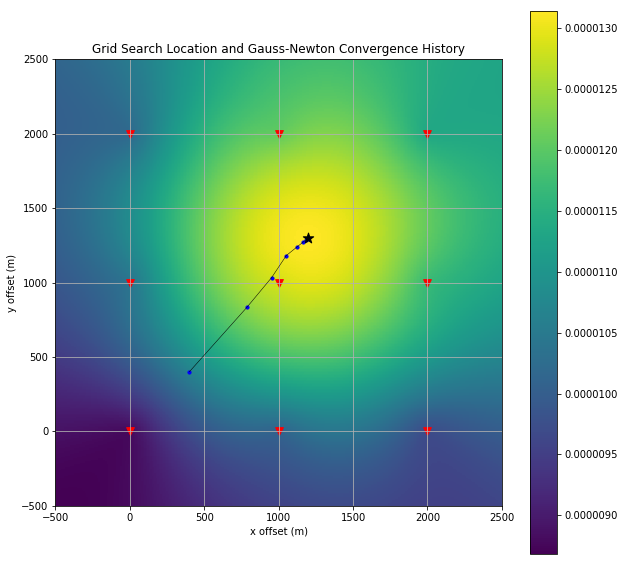

In [9]:
# Plot the results from the Gauss-Newton and grid-search optimization
plt.figure(figsize=(10,10)) 
plt.imshow(likelihood.T, extent=[min(x), max(x), min(y), max(y)], origin='lower')
plt.xlabel('x offset (m)')
plt.ylabel('y offset (m)')
plt.title("Grid Search Location and Gauss-Newton Convergence History")
plt.grid(True)
plt.colorbar()
# We typically plot stations as (inverted) triangles
plt.scatter(xr, yr, c='red', marker='v', s=60)
# Extract the convergence history
niter = len(models_gn)
xconv = zeros(niter)
yconv = zeros(niter)
for i in range(niter):
    xconv[i] = models_gn[i][0]
    yconv[i] = models_gn[i][1]
# Plot the convergence history
plt.plot(xconv, yconv, c='black', linewidth=0.5)
plt.scatter(xconv, yconv, c='blue', marker='o', s=10)
# Plot the true source location as a black star
plt.scatter(xs_true, ys_true, c='black', marker='*', s=120)
plt.show()

# Questions

Does the Gauss-Newton method or grid-search take less computational time?

In this instance, both methods identified the true source location.  Do you find the Gauss-Newton method more informative than the result of the grid-search?

Notice that the Gauss-Newton method quickly converges on a minimum.  For more interesting acquisition geometries and velocity models the objective function can have multiple minima.  In general, would you prefer Gauss-Newton or grid-search?

## Graduate Students

Rewrite the grid-search function to optimize an $L_1$ misfit function.  In this case the origin time optimization amounts to computing the median residual travel time.  Plot the result.  Comment on the robustness of $L_1$ vs $L_2$ norms.  